In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


from utilities import *
from crossValidation import *
from features import *

In [2]:
df1 = pd.read_csv('Analysis/data/full_5m_futures/LUNA2USDT_futures_5m_202209_202405.csv',  usecols=['Time', 'Close'],memory_map=True)
df2 = pd.read_csv('Analysis/data/full_5m_futures/1000LUNCUSDT_futures_5m_202209_202405.csv', usecols=['Time', 'Close'],memory_map=True)

df1.Time = pd.to_datetime(df1.Time, unit='ms')
df2.Time = pd.to_datetime(df2.Time, unit='ms')
df1.set_index('Time', inplace=True)
df2.set_index('Time', inplace=True)

# common_start = pd.to_datetime("2022-01-01")
# common_end =None# pd.to_datetime("2023-12-31")

# df1 = df1.loc[common_start:common_end]
# df2 = df2.loc[common_start:common_end]

intersected_indices = df1.index.intersection(df2.index)
df1 = df1.loc[intersected_indices]
df2 = df2.loc[intersected_indices]

lookback = 200
step = 50
y = getPathMatrix(np.log(df1.Close), df1[lookback:][::step].index, lookback, scale = 1)
x = getPathMatrix(np.log(df2.Close), df2[lookback:][::step].index, lookback, scale = 1)

slope, intercept = vectorized_linear_regression(y.values,x.values)

In [3]:
beta = pd.Series(slope, index = y.index).rolling(window = 1000, min_periods = 50).mean()
# beta = pd.Series(slope, index = y.index).expanding(min_periods = 50).mean()

In [4]:
beta = pd.Series(index = df1.index, data = beta).bfill().ffill()

In [5]:
beta

Time
2022-09-10 03:00:00    0.709304
2022-09-10 03:05:00    0.709304
2022-09-10 03:10:00    0.709304
2022-09-10 03:15:00    0.709304
2022-09-10 03:20:00    0.709304
                         ...   
2024-05-31 23:35:00    0.864379
2024-05-31 23:40:00    0.864379
2024-05-31 23:45:00    0.864379
2024-05-31 23:50:00    0.864379
2024-05-31 23:55:00    0.864379
Length: 181404, dtype: float64

<Axes: xlabel='Time'>

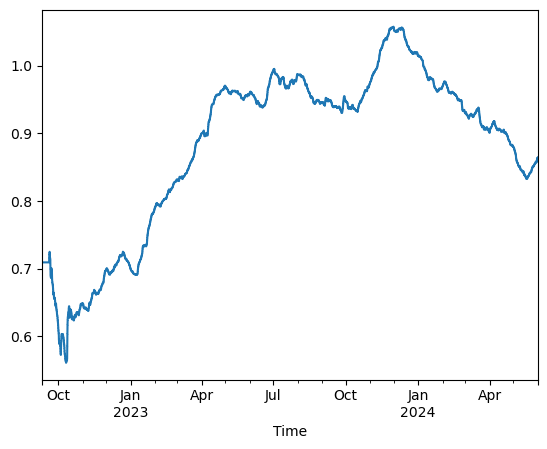

In [6]:
beta.plot()

In [7]:
beta

Time
2022-09-10 03:00:00    0.709304
2022-09-10 03:05:00    0.709304
2022-09-10 03:10:00    0.709304
2022-09-10 03:15:00    0.709304
2022-09-10 03:20:00    0.709304
                         ...   
2024-05-31 23:35:00    0.864379
2024-05-31 23:40:00    0.864379
2024-05-31 23:45:00    0.864379
2024-05-31 23:50:00    0.864379
2024-05-31 23:55:00    0.864379
Length: 181404, dtype: float64

In [8]:
# beta = 1

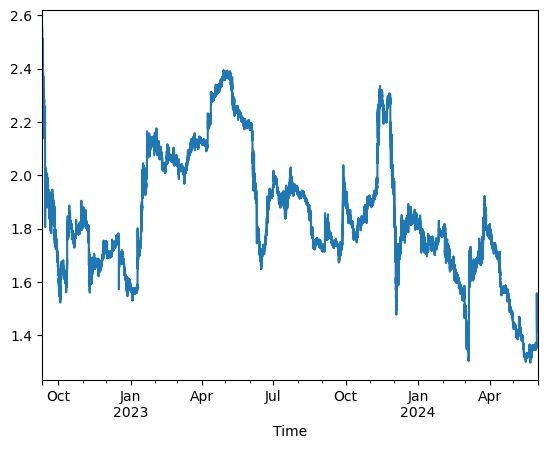

In [9]:

spread = pd.DataFrame()
spread['Close'] = np.log(df1.Close)-np.log(df2.Close)*beta
# spread['Close'] = df1.Close-df2.Close*beta
spread['barID'] = spread.reset_index().index.values
vol1 = spread.Close.ewm(span = 100).std()
vol2 = spread.Close.rolling(100).std()
spread['vol'] = vol1
spread.Close.plot();plt.show()
zscore = getBollinger(spread.Close, lookback= 100, use_log = False)
# zscore = getTrendBlgr(spread.index[100:], spread.Close, 100, 1, use_log = False)

In [12]:
# Get Samples (events)
commission = 0.001
slippage = 0.0004*2 # 들어갈때 나올때
minVol = (commission+slippage)*2
targetVol = 0.015
start = pd.to_datetime("2022-01-01")
events = getCrossingEvents_dynamicExit(zscore[start:], spread, entry_thres=-3, exit_thres1=0, entry_cross='downward', exit_cross1='upward', 
                                       exit_thres2 = None, exit_cross2='downward', mid= 0, minVol = minVol,vol=spread['vol'])

ret1 = get_lrets(events, df1, commission = commission+slippage, side='long', betSize = 1)
ret2 = get_lrets(events, df2, commission = commission+slippage, side='short', betSize = beta)
ret = ret1 + ret2
events['ret1'] = ret1
events['ret2'] = ret2
events['ret'] = ret


lev_adj = spread['vol'][ret.index]/targetVol
ret = np.log((np.exp(ret)-1)/lev_adj + 1)
events['ret_adj'] = ret

<Axes: xlabel='Time'>

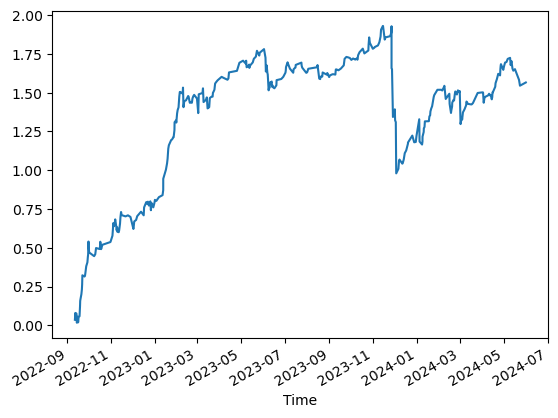

In [13]:
ret.cumsum().plot()

In [14]:
# Get Samples (events)
events = getCrossingEvents_dynamicExit(zscore[start:], spread, entry_thres=3, exit_thres1=0, entry_cross='upward', exit_cross1='downward', 
                                       exit_thres2 = None, exit_cross2='downward', mid= 0, minVol = minVol,vol=spread['vol'])

ret1 = get_lrets(events, df1, commission = commission+slippage, side='short', betSize = 1)
ret2 = get_lrets(events, df2, commission = commission+slippage, side='long', betSize = beta)
ret = ret1 + ret2
events['ret1'] = ret1
events['ret2'] = ret2
events['ret'] = ret


# lev_adj = spread['vol'][ret.index]/targetVol
# ret = np.log((np.exp(ret)-1)/lev_adj + 1)
# events['ret_adj'] = ret

<Axes: xlabel='Time'>

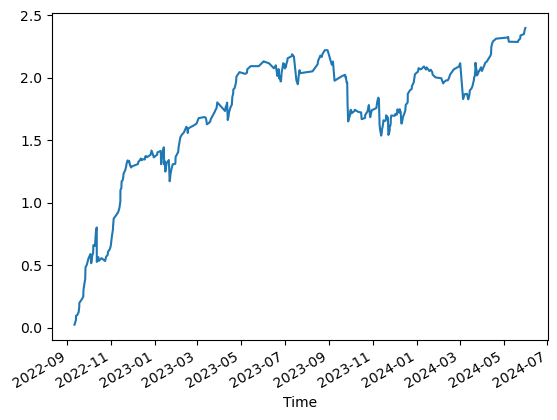

In [21]:
ret.cumsum().plot()

In [15]:
events_b = events.copy()

In [54]:
events_combined = pd.concat([events_a,events_b],axis = 0).sort_index()

In [55]:
# Save Model
import pickle
with open('Analysis/[S4] LUNA_Pair/events.pkl', 'wb') as f:
    pickle.dump(events_combined, f)